# Collecting diagnostic data during radiative transfer calculation with HR

In this example we collect diagnostic data, namely in- and out-radiance at specified diffuse profiles and orders of scattering, and store it to an hdf5 file. To enable data collection, at least one of the following two HR engine options should be set:

- diagnosticscatterorders    -   the list of orders of scattering,

- diagnosticdiffuseprofiles  -   the list of diffuse profiles.

If only one option is set manually, the second will be set to default value. Deafults are [1] for the scattering orders and [0] for the diffuse profiles.

The data is stored to DiagnosticData.h5 file in the working directory. If the file already exists, it is overwritten.

To stop collecting diagnostic data without re-initializing the engine, one should set both parameters to zero-length arrays: engine.options['optname'] = [].

In [1]:
%matplotlib inline

In [2]:
import sasktran as sk
from sasktran.geometry import VerticalImage
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [3]:
# Create geometry
tanalts = [15, 25, 35]
geometry = VerticalImage()
geometry.from_sza_saa(sza=60, saa=60, lat=0, lon=0, tanalts_km=tanalts, mjd=54372, 
                      locallook=0, satalt_km=600, refalt_km=20)

# Create an atmosphere with aerosol absorption and Rayleigh scattering
atmosphere = sk.Atmosphere()
atmosphere['air'] = sk.Species(optical_property=sk.Rayleigh(), climatology=sk.MSIS90())

engine = sk.EngineHR(geometry=geometry, atmosphere=atmosphere)
wlens = [350, 400]
engine.wavelengths = wlens

# To collect diagnostic data,
# specify scattering orders
myorders = [1,2,3]
engine.options['diagnosticscatterorders'] = myorders

# Use more than one diffuse profile
engine.options['numdiffuseprofilesinplane'] = 3

myprofiles = [0,1,2]
engine.options['diagnosticdiffuseprofiles'] = myprofiles

# Execute
rad = engine.calculate_radiance()

One can have a look at the list of data that was collected:

In [4]:
h5f = h5py.File('DiagnosticData.h5', 'r')
print('The following diagnostic data was stored:')
for k in h5f.keys():
    dsinf = str(h5f[k])
    print(dsinf[14:dsinf.find(')')+1])
h5f.close()

The following diagnostic data was stored:
"heights": shape (102,)
"in_wlen_350.00_ord_1_ground": shape (3, 133)
"in_wlen_350.00_ord_1_prof_0": shape (102, 290, 4)
"in_wlen_350.00_ord_1_prof_1": shape (102, 290, 4)
"in_wlen_350.00_ord_1_prof_2": shape (102, 290, 4)
"in_wlen_350.00_ord_2_ground": shape (3, 133)
"in_wlen_350.00_ord_2_prof_0": shape (102, 290, 4)
"in_wlen_350.00_ord_2_prof_1": shape (102, 290, 4)
"in_wlen_350.00_ord_2_prof_2": shape (102, 290, 4)
"in_wlen_350.00_ord_3_ground": shape (3, 133)
"in_wlen_350.00_ord_3_prof_0": shape (102, 290, 4)
"in_wlen_350.00_ord_3_prof_1": shape (102, 290, 4)
"in_wlen_350.00_ord_3_prof_2": shape (102, 290, 4)
"in_wlen_400.00_ord_1_ground": shape (3, 133)
"in_wlen_400.00_ord_1_prof_0": shape (102, 290, 4)
"in_wlen_400.00_ord_1_prof_1": shape (102, 290, 4)
"in_wlen_400.00_ord_1_prof_2": shape (102, 290, 4)
"in_wlen_400.00_ord_2_ground": shape (3, 133)
"in_wlen_400.00_ord_2_prof_0": shape (102, 290, 4)
"in_wlen_400.00_ord_2_prof_1": shape (102

In [5]:
# Keep the first file under different name
import os
def convert_bytes(num):
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0
def file_size(file_path):
   if os.path.isfile(file_path):
        file_info = os.stat(file_path)
        return convert_bytes(file_info.st_size)

fname = 'DiagnosticData.h5'
# print the file size    
print(fname, ' :', file_size(fname))  

DiagnosticData.h5  : 25.9 MB


In [6]:
# To dismiss collecting diagnostic data:
engine.options['diagnosticscatterorders'] = []
engine.options['diagnosticdiffuseprofiles'] = []

# Execute
rad = engine.calculate_radiance()

Note: for polarized light scattering, the shape of incoming radiance data is (nheights, npoints, 10), and row structure is [x, y, z, rad, true_x, true_y, true_z, stokes_x, stokes_y, stokes_z]


Following are two useful plotting functions to visualize the collected data.

In [7]:
def plotOnSphere(fname, wlen, type = 'in', order = 1, profile = 0, height=4500, 
                 mycolormap = plt.cm.coolwarm):
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    from scipy.spatial import ConvexHull
    import matplotlib.colors as colors
    
    h5f = h5py.File(fname, 'r')
    heights = np.array( h5f.get('heights') )
    # get 3d rad data 
    # non-polarized: [heights][points][x y z rad]
    # polarized: [heights][points][x y z rad tru_x tru_y tru_z stokes_x stokes_y stokes_z]
    rads = np.array( h5f.get(type + '_wlen_' + '%.2f'%wlen + '_ord_' + str(order) +
                             '_prof_' + str(profile)) )
    h5f.close()
    
    hidx = np.abs(heights-height).argmin()
    rad = rads[hidx]
    rad = rad[np.argsort(rad[:,3])]
    xyz, rvals = rad[:,0:3], rad[:,3]

    hull = ConvexHull(xyz)
    idxs = hull.simplices
    verts = xyz[idxs]
    facevals = np.average(rvals[idxs], axis=1)
    mynorm = plt.Normalize(min(facevals), max(facevals))
    facecols = mycolormap(mynorm(facevals))

    coll = Poly3DCollection(verts, facecolors=facecols, edgecolors='white', linewidths=0.1)

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(projection='3d')
    ax.add_collection(coll)
    ax.axis([-1, 1,-1, 1]), ax.set_zlim(-1, 1)
    ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')

    m = plt.cm.ScalarMappable(cmap=mycolormap)
    m.set_array([min(facevals),max(facevals)])
    fig.colorbar(m, shrink=0.5, aspect=15, ticks=np.linspace(min(facevals), 
                                                             max(facevals), 10))
    plt.tight_layout()
    plt.title(type+' radiance, wavelength = ' + '%.2f'%wlen + 
              '; profile = ' + str(profile) + '; order of scatter = ' + 
              str(order) + '; height = ' + str(height))
    plt.show()
    plt.close()

def plot2DHeightProf(fname, wlen, type = 'in', orders=[1,2,3], profile=0, point = [0. ,0., 1.], 
                     theta = None, phi = None, np2int = 4):
    # where np2int is a number of points to interpolate
    # and the target point can be specified either as [x y z] or as {theta, phi}    
    if (theta is not None) and (phi is not None):
        theta = np.radians(theta)
        phi = np.radians(phi)
        point[0] = np.sin(theta)*np.cos(phi)
        point[1] = np.sin(theta)*np.sin(phi)
        point[2] = np.cos(theta)
        
    h5f = h5py.File(fname, 'r')
    heights = np.array( h5f.get('heights') )
    h5f.close()
    mylegend = []
    fig = plt.figure(figsize=(12,8))
    for order in orders:
        rads = []
        h5f = h5py.File(fname, 'r')
        # get 3d rad data 
        # n/pol.: [heights][points][x y z rad]
        # pol.: [heights][points][x y z rad tru_x tru_y tru_z stokes_x stokes_y stokes_z]
        rad = np.array( h5f.get(type + '_wlen_' + '%.2f'%wlen + '_ord_' + 
                                str(order) + '_prof_' + str(profile)) )
        h5f.close()
        for hidx in range(len(rad)):
            mynum, myden = 0, 0
            mags = np.linalg.norm(rad[hidx,:,0:3] - point, axis=1)
            if ( mags[np.argmin(mags)] < 1e-6 ) or ( np2int == 1 ): 
                #if perfect match found, ignore np2int
                rads.append(rad[hidx, np.argmin(mags), 3])
            else:
                # use modified Shepard interp. for limited num. points
                my_radius = mags[np.argsort(mags)[np2int]]
                for npt in range(np2int):
                    coef = pow( max( 0, my_radius-mags[np.argsort(mags)[npt]]) / 
                    ( mags[np.argsort(mags)[npt]] * my_radius), 2)
                    mynum += coef * rad[hidx, np.argsort(mags)[npt], 3]
                    myden += coef
                rads.append( mynum / myden )
        mylegend.append('scat.ord. ' + str(order))
        plt.plot(rads, heights)
    plt.legend(mylegend)
    plt.ylabel('height (m)')
    plt.xlabel(type + '. rad.')
    if np2int == 1: subtitle = 'Nearest-neighbor interpolation'
    else: subtitle = str(np2int) + '-pt interpolation'
    plt.title(type + '. rad. at the point ' + 
              "[%s]"%", ".join(map(str,np.around(point,decimals=3))) +
              '; ' + subtitle)
    plt.show()
    plt.close()

/tmp/ipykernel_3227/2621053390.py:9: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  heights = np.array( h5f.get('heights') )
/tmp/ipykernel_3227/2621053390.py:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  rads = np.array( h5f.get(type + '_wlen_' + '%.2f'%wlen + '_ord_' + str(order) +
/tmp/ipykernel_3227/2621053390.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(m, shrink=0.5, aspect=15, ticks=np.linspace(min(facevals),


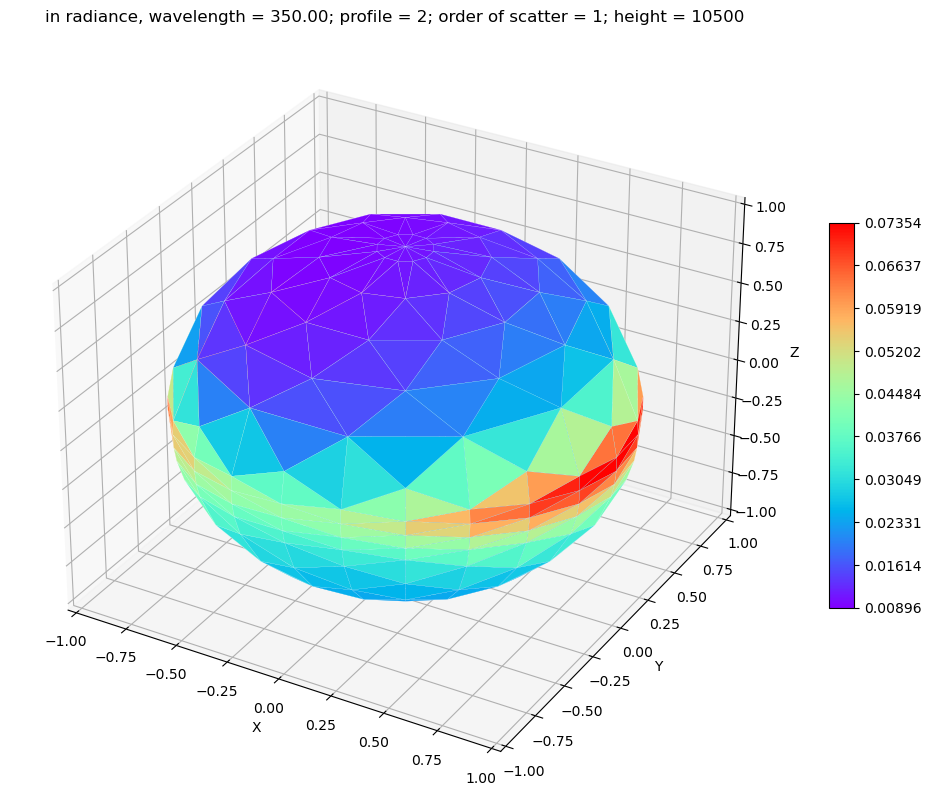

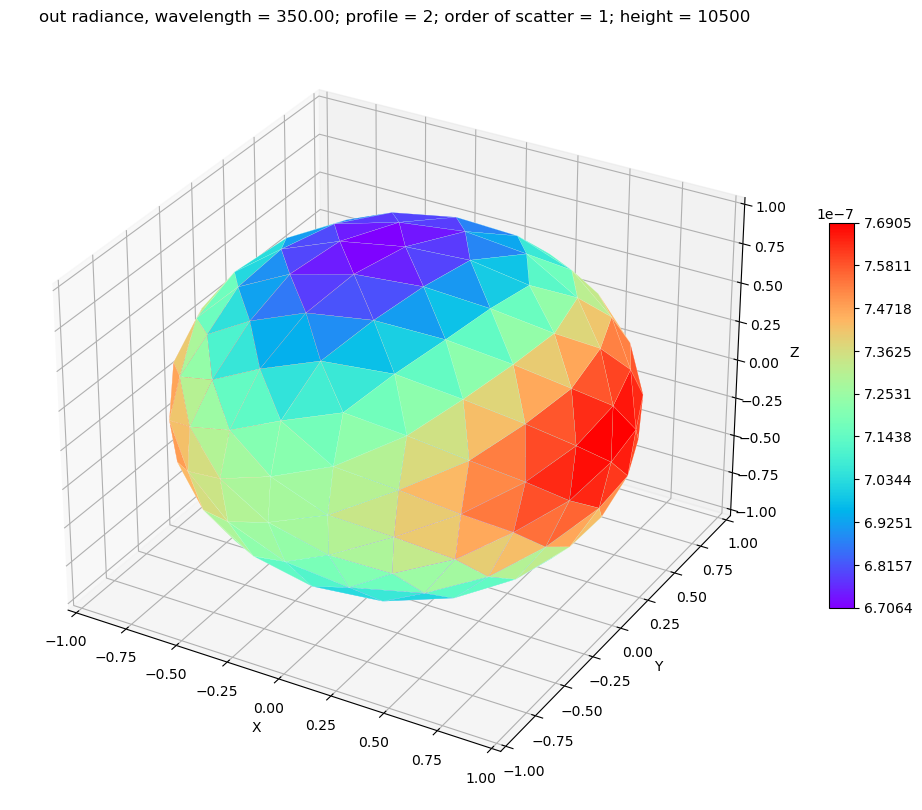

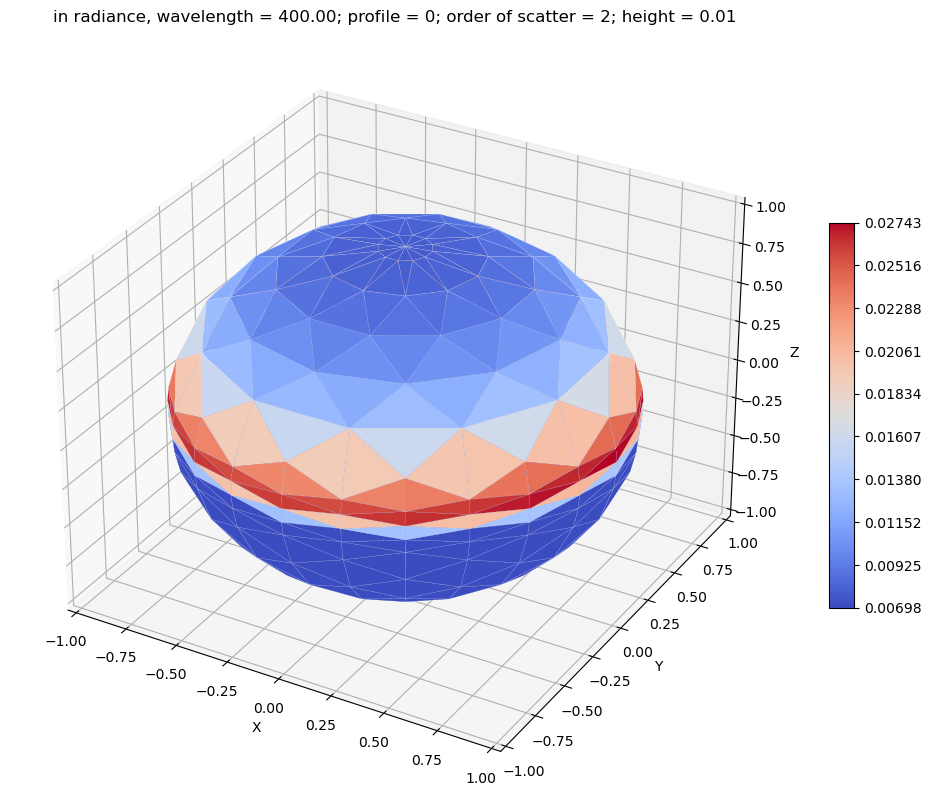

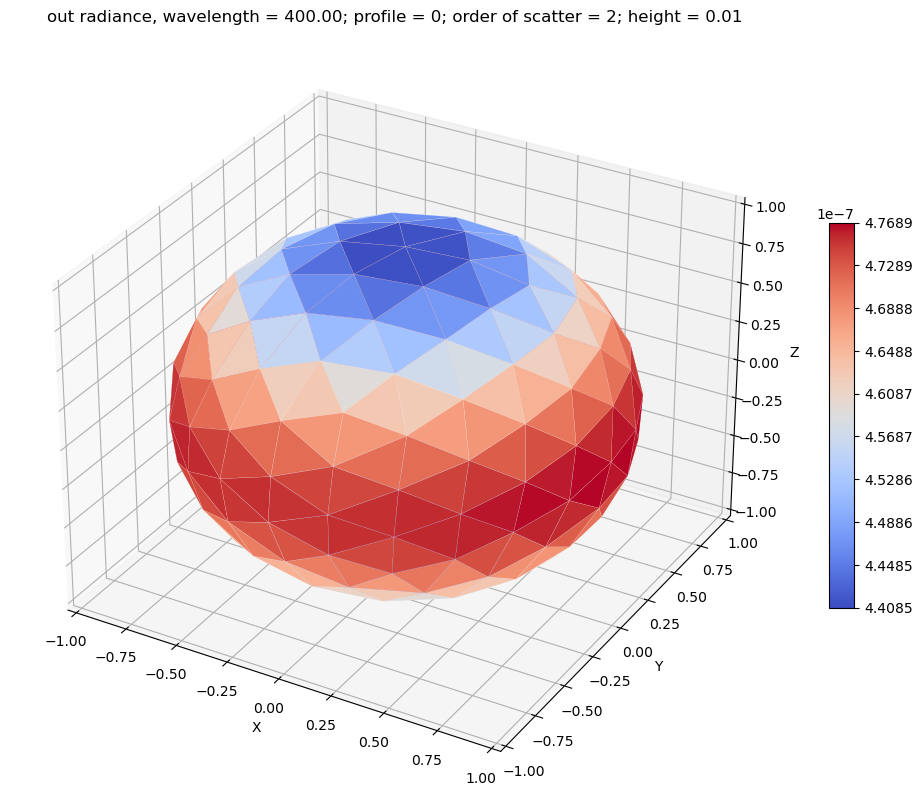

In [8]:
fname = 'DiagnosticData.h5'

# - plot on unisphere, one plot per one order, profile, height
plotOnSphere(fname, 350, 'in', order=1, profile=2, height=10500, mycolormap = plt.cm.rainbow)
plotOnSphere(fname, 350, 'out', order=1, profile=2, height=10500, mycolormap = plt.cm.rainbow)
# - plot on unisphere, one plot per one order, profile, height
plotOnSphere(fname, 400, 'in', order=2, profile=0, height=0.01)
plotOnSphere(fname, 400, 'out', order=2, profile=0, height=0.01)

/tmp/ipykernel_3227/2621053390.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  heights = np.array( h5f.get('heights') )
/tmp/ipykernel_3227/2621053390.py:70: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  rad = np.array( h5f.get(type + '_wlen_' + '%.2f'%wlen + '_ord_' +


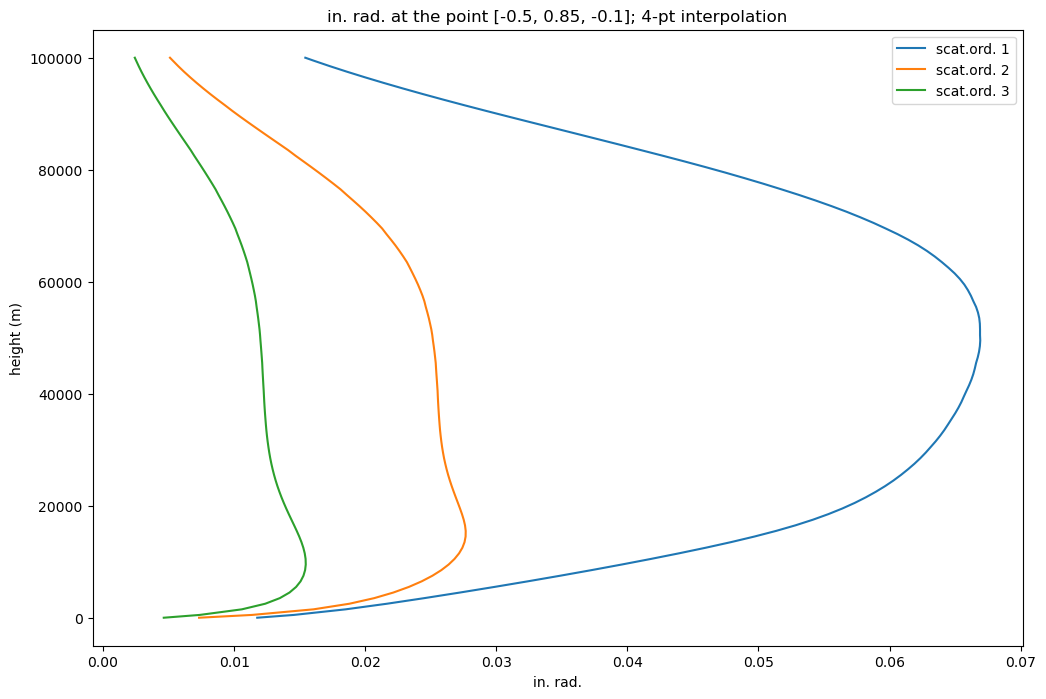

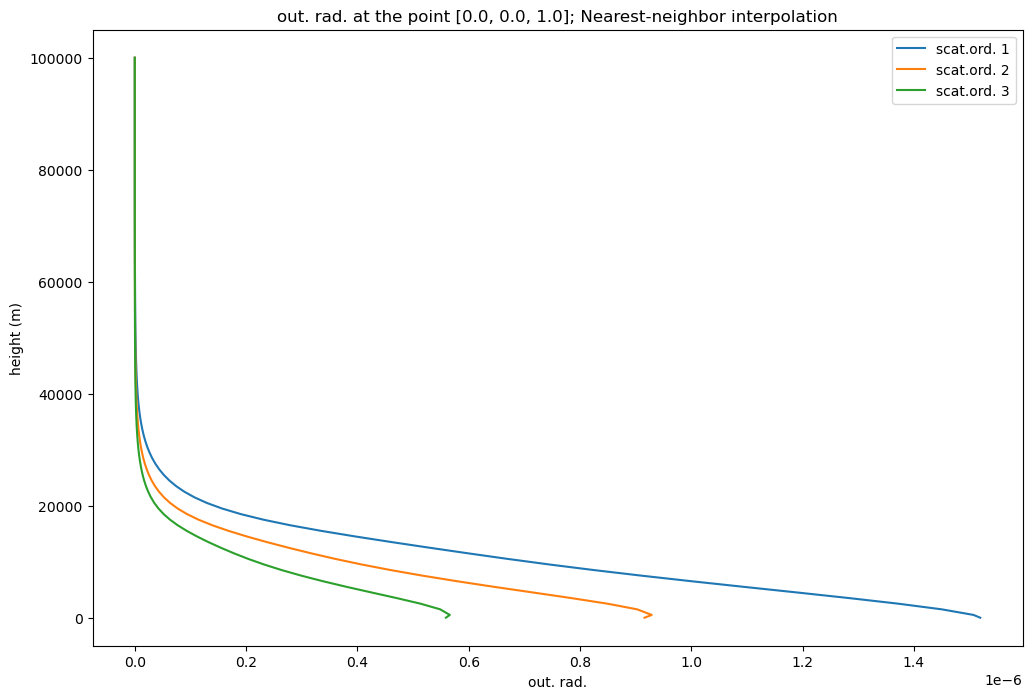

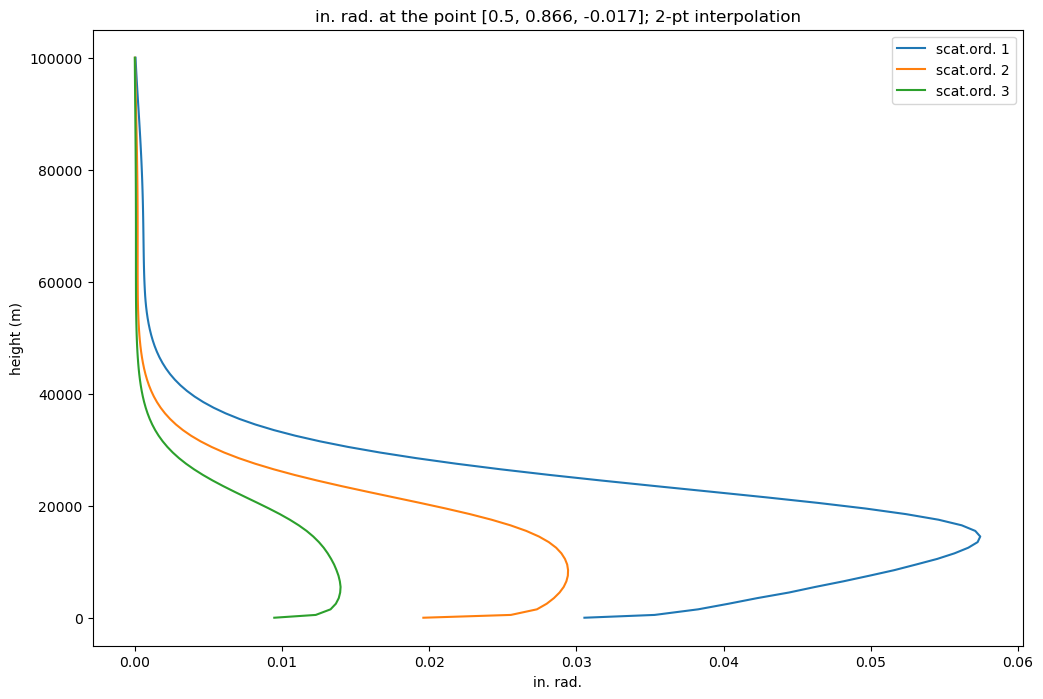

In [9]:
fname = 'DiagnosticData.h5'
# - or plot a height profile for particular diffuse point
plot2DHeightProf(fname, 350, orders=myorders, profile=0, point=[-0.5,  0.85, -0.1])
plot2DHeightProf(fname, 350, type='out', orders=myorders, profile=2, np2int=1)
plot2DHeightProf(fname, 400, theta=91, phi=60, np2int=2)